In [1]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer #어간추출
from gensim import corpora, models
import matplotlib.pyplot as plt #시각화를 위한
import gensim
import pandas as pd
#import string
#import re
#from konlpy.tag import Twitter #설치 에러
#from wordcloud import WordCloud #설치 에러
#from collections import Counter

In [2]:
tt = pd.read_csv("./data/tt.csv", encoding="ISO-8859-1")
spam = pd.read_csv("./data/spam.csv", encoding="ISO-8859-1")
spam_test = pd.read_csv("./data/spam_test.csv", encoding="ISO-8859-1")
ham = pd.read_csv("./data/ham.csv", encoding="ISO-8859-1")
ham_test = pd.read_csv("./data/ham_test.csv", encoding="ISO-8859-1")

In [3]:
tt.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
del tt['Unnamed: 2']
del tt['Unnamed: 3']
del tt['Unnamed: 4']
tt.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#ham은 0으로, spam은 1로 변환
tt['v1']=tt['v1'].replace(['ham','spam'],[0,1])
tt.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
tt.info()
#v1은 0과 1로 된 int형 
#v2는 object 문자열 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 65.4+ KB


In [7]:
#null 값이 있는지 확인  -->결과 Null 값이 존재하지 않음
tt.isnull().values.any()

False

In [8]:
#중복데이터가 있는지 확인  -->5,572-5,169 = 403개의 중복 샘플 존재
tt['v2'].nunique(), tt['v1'].nunique()
#중복 제거
tt.drop_duplicates(subset=['v2'], inplace=True)
print(len(tt)) #데이터 수 확인

5169


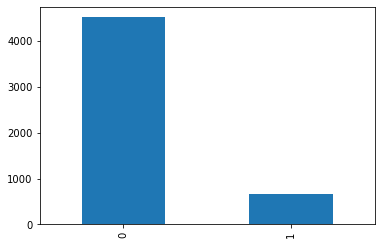

In [9]:
#data에 존재하는 spam과 ham의 데이터 수를 확인
tt['v1'].value_counts().plot(kind='bar')

##### SMS메세지 중 대부분이 정상 메일이고 소수가 스팸메일이라는 것을 알 수 있다. 

In [10]:
print(tt.groupby('v1').size()) #v1에 있는 ham(0)개수와 spam(1)개수를 보여줌

v1
0    4516
1     653
dtype: int64


In [11]:
'''
x_tt = tt['v2'] #SMS 메세지 (input data)
y_tt = tt['v1'] #f레이블: ham(0)이냐 spam(1)이냐 
'''

"\nx_tt = tt['v2'] #SMS 메세지 (input data)\ny_tt = tt['v1'] #f레이블: ham(0)이냐 spam(1)이냐 \n"

In [12]:
type(tt) #dataFrame으로 분류 됨!

pandas.core.frame.DataFrame

In [13]:
spam_list=list(spam['v2'])
ham_list=list(ham['v2'])

In [14]:
#spam_list 안의 문서를 읽어서 전처리 후 다시 저장
tokenizer = RegexpTokenizer(r'\w+') # 문장을 단어로 분리하는 모듈
#pattern='[^\w\s]' #특수문자제거
#repl='' #특수문자제거
stop = get_stop_words('en')         # 불용어 리스트
stemmer = PorterStemmer()           # 어간 추출기 ex)'나는 학교에 간다' -> '나 학교 가' 
spam1 = []                          # 전처리 후 문서 저장하는 리스트
for d in spam_list:
    if(d) :
        raw = d.lower()
 #       raw = re.sub(pattern=pattern, repl=repl, string=raw)
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop]
        stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
        spam1.append(stemmed_tokens)

In [15]:
#ham_list 안의 문서를 읽어서 전처리 후 다시 저장
tokenizer = RegexpTokenizer(r'\w+') # 문장을 단어로 분리하는 모듈
stop = get_stop_words('en')         # 불용어 리스트
stemmer = PorterStemmer()           # 어간 추출기 ex)'나는 학교에 간다' -> '나 학교 가' 
ham1 = []                          # 전처리 후 문서 저장하는 리스트
for d in ham_list:
    if(d) :
        raw = d.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop]
        stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
        ham1.append(stemmed_tokens)

In [16]:
### LDA 모델을 적용하기 위해 document-term matrix 형태를 만들어줌
# 전체 문서가 포함하고 있는 모든 단어로 이루어진 사전
spam1_dictionary = corpora.Dictionary(spam1) 
spam1_dictionary
# spam1 문서를 이용하여 doc-term matrix를 만들어줌
spam1_corpus = [spam1_dictionary.doc2bow(text) for text in spam1]
# 단어 빈도수가 아닌 tfidf 가중치를 적용한 모델
spam1_tfidf = models.TfidfModel(spam1_corpus, id2word = spam1_dictionary)
# tfidf 모델로 corpus를 적용한 결과
spam1_corpus_tfidf = spam1_tfidf[spam1_corpus]
# 위의 결과를 다시 LDA를 적용하기 위한 list 형태로 변형
spam1_corpus_tfidf_list = [doc for doc in spam1_corpus_tfidf]      

In [17]:
#LDA 모델 학습
sp_ldamodel = gensim.models.ldamodel.LdaModel(spam1_corpus_tfidf_list, num_topics=3, id2word = spam1_dictionary, passes=50)
print(sp_ldamodel.print_topics(num_topics=20, num_words=20)) #학습결과 상위 단어 20개까지

[(0, '0.006*"free" + 0.004*"call" + 0.004*"cash" + 0.004*"text" + 0.004*"ur" + 0.003*"å" + 0.003*"txt" + 0.003*"servic" + 0.003*"4" + 0.003*"500" + 0.003*"mobil" + 0.003*"u" + 0.003*"tone" + 0.003*"pleas" + 0.003*"rington" + 0.003*"now" + 0.003*"latest" + 0.003*"2" + 0.003*"messag" + 0.003*"phone"'), (1, '0.007*"claim" + 0.006*"prize" + 0.006*"å" + 0.005*"won" + 0.005*"call" + 0.004*"u" + 0.004*"2" + 0.004*"award" + 0.004*"now" + 0.004*"tri" + 0.003*"nokia" + 0.003*"contact" + 0.003*"mobil" + 0.003*"urgent" + 0.003*"guarante" + 0.003*"receiv" + 0.003*"show" + 0.003*"number" + 0.003*"2000" + 0.003*"min"'), (2, '0.004*"stop" + 0.003*"day" + 0.003*"repli" + 0.003*"txt" + 0.003*"2" + 0.003*"import" + 0.002*"com" + 0.002*"www" + 0.002*"1" + 0.002*"dog" + 0.002*"get" + 0.002*"camera" + 0.002*"club" + 0.002*"messag" + 0.002*"text" + 0.002*"inform" + 0.002*"s" + 0.002*"http" + 0.002*"flag" + 0.002*"servic"')]


In [18]:
### LDA 모델을 적용하기 위해 document-term matrix 형태를 만들어줌
# 전체 문서가 포함하고 있는 모든 단어로 이루어진 사전
ham1_dictionary = corpora.Dictionary(ham1) 
ham1_dictionary
# ham1 문서를 이용하여 doc-term matrix를 만들어줌
ham1_corpus = [ham1_dictionary.doc2bow(text) for text in ham1]
# 단어 빈도수가 아닌 tfidf 가중치를 적용한 모델
ham1_tfidf = models.TfidfModel(ham1_corpus, id2word = ham1_dictionary)
# tfidf 모델로 corpus를 적용한 결과
ham1_corpus_tfidf = ham1_tfidf[ham1_corpus]
# 위의 결과를 다시 LDA를 적용하기 위한 list 형태로 변형
ham1_corpus_tfidf_list = [doc for doc in ham1_corpus_tfidf]  

In [19]:
#LDA 모델 학습
h_ldamodel = gensim.models.ldamodel.LdaModel(ham1_corpus_tfidf_list, num_topics=3, id2word = ham1_dictionary, passes=50)
print(h_ldamodel.print_topics(num_topics=20, num_words=20)) #학습결과 상위 단어 20개까지

[(0, '0.012*"gt" + 0.011*"lt" + 0.007*"pl" + 0.005*"send" + 0.005*"u" + 0.004*"new" + 0.004*"year" + 0.004*"s" + 0.003*"need" + 0.003*"right" + 0.003*"min" + 0.003*"messag" + 0.003*"bu" + 0.003*"k" + 0.003*"done" + 0.003*"phone" + 0.002*"get" + 0.002*"pick" + 0.002*"way" + 0.002*"ya"'), (1, '0.012*"call" + 0.010*"ll" + 0.010*"ok" + 0.008*"later" + 0.007*"sorri" + 0.007*"can" + 0.006*"know" + 0.005*"s" + 0.005*"meet" + 0.005*"t" + 0.005*"m" + 0.005*"u" + 0.005*"da" + 0.005*"see" + 0.004*"get" + 0.004*"dont" + 0.004*"dear" + 0.004*"text" + 0.004*"ye" + 0.004*"now"'), (2, '0.010*"u" + 0.008*"go" + 0.007*"come" + 0.007*"home" + 0.007*"2" + 0.006*"lor" + 0.006*"m" + 0.005*"will" + 0.005*"4" + 0.005*"wat" + 0.005*"now" + 0.004*"time" + 0.004*"s" + 0.004*"get" + 0.004*"just" + 0.004*"alreadi" + 0.004*"can" + 0.004*"ok" + 0.003*"want" + 0.003*"thank"')]


In [20]:
#토픽별 결과
sp_result=sp_ldamodel.show_topic(2,30)
print(sp_result)

[('stop', 0.003958376), ('day', 0.003102089), ('repli', 0.0028713972), ('txt', 0.002820651), ('2', 0.002653397), ('import', 0.0026464593), ('com', 0.0022706268), ('www', 0.0022399838), ('1', 0.0022154383), ('dog', 0.0022133398), ('get', 0.0021517372), ('camera', 0.002057588), ('club', 0.0020502508), ('messag', 0.001981176), ('text', 0.001954823), ('inform', 0.0019366633), ('s', 0.0019290594), ('http', 0.0018817139), ('flag', 0.001862433), ('servic', 0.0018459309), ('msg', 0.0018256844), ('announc', 0.0018235178), ('end', 0.0017747986), ('now', 0.0017652067), ('u', 0.0017279586), ('f', 0.0017010131), ('win', 0.001697262), ('mobil', 0.001695213), ('50', 0.0016943801), ('3', 0.001670775)]


In [21]:
#토픽별 결과
h_result=h_ldamodel.show_topic(2,30)
print(h_result)

[('u', 0.009996082), ('go', 0.008210974), ('come', 0.007281132), ('home', 0.0066782697), ('2', 0.006516254), ('lor', 0.0061527328), ('m', 0.0058141514), ('will', 0.005471852), ('4', 0.005206049), ('wat', 0.0047958707), ('now', 0.004560252), ('time', 0.004299028), ('s', 0.003941986), ('get', 0.00367792), ('just', 0.0036657273), ('alreadi', 0.0035707734), ('can', 0.0035337664), ('ok', 0.0035144812), ('want', 0.0034309279), ('thank', 0.0034283698), ('got', 0.003334227), ('love', 0.0032634998), ('n', 0.0032174995), ('day', 0.003161417), ('k', 0.0031012066), ('im', 0.003022131), ('week', 0.0030217285), ('good', 0.0029835026), ('hope', 0.0029548667), ('today', 0.0029316451)]


In [22]:
'''
def sp_h (x):
    #spam_list 안의 문서를 읽어서 전처리 후 다시 저장
    tokenizer = RegexpTokenizer(r'\w+') # 문장을 단어로 분리하는 모듈
    #pattern='[^\w\s]' #특수문자제거
    #repl='' #특수문자제거
    stop = get_stop_words('en')         # 불용어 리스트
    stemmer = PorterStemmer()           # 어간 추출기 ex)'나는 학교에 간다' -> '나 학교 가' 
    x1 = []                          # 전처리 후 문서 저장하는 리스트
    for d in x:
        if(d) :
            raw = d.lower()
             #raw = re.sub(pattern=pattern, repl=repl, string=raw)
            tokens = tokenizer.tokenize(raw)
            stopped_tokens = [i for i in tokens if not i in stop]
            stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
            x1.append(stemmed_tokens)
    
    ### LDA 모델을 적용하기 위해 document-term matrix 형태를 만들어줌
    # 전체 문서가 포함하고 있는 모든 단어로 이루어진 사전
    x_dictionary = corpora.Dictionary(x1) 
    x_dictionary
    # ham1 문서를 이용하여 doc-term matrix를 만들어줌
    x_corpus = [x_dictionary.doc2bow(text) for text in x1]
    # 단어 빈도수가 아닌 tfidf 가중치를 적용한 모델
    x_tfidf = models.TfidfModel(x_corpus, id2word = x_dictionary)
    # tfidf 모델로 corpus를 적용한 결과
    x_corpus_tfidf = x_tfidf[x_corpus]
    # 위의 결과를 다시 LDA를 적용하기 위한 list 형태로 변형
    x_corpus_tfidf_list = [doc for doc in x_corpus_tfidf] 
    #LDA 모델 학습
    x_ldamodel = gensim.models.ldamodel.LdaModel(x_corpus_tfidf_list, num_topics=3, id2word = x_dictionary, passes=50)
    #결과
    x_result=x_ldamodel.show_topic(2,30)
    
    temp1=0
    temp2=0
    for x1, y1 in x_result:
        for sp_x, sp_y in sp_result:
            num=0
            if(x1==sp_x):
                num=1
                temp1=temp1+sp_y
        for h_x, h_y in h_result:
            num=0
            if(x1==h_x):
                temp2=temp2+h_y
    
    if(temp1>temp2):
        print('spam')
    if(temp1<temp2):
        print('ham')
    if(temp1==temp2):
        print('??')


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-22-7d4cbafa0c7e>, line 54)

In [ ]:
'''
spam_test1=spam_test.head(8)
x=list(spam_test1['v2'])
sp_h(x)

In [23]:
sp_df=pd.DataFrame(sp_result)
sp_df.head(20)

,0,1
0,stop,0.003958
1,day,0.003102
2,repli,0.002871
3,txt,0.002821
4,2,0.002653
5,import,0.002646
6,com,0.002271
7,www,0.002240
8,1,0.002215
9,dog,0.002213


In [24]:
h_df=pd.DataFrame(h_result)
h_df.head(20)

,0,1
0,u,0.009996
1,go,0.008211
2,come,0.007281
3,home,0.006678
4,2,0.006516
5,lor,0.006153
6,m,0.005814
7,will,0.005472
8,4,0.005206
9,wat,0.004796
